# Emotion Classification of Tweets

### Import libraries and load dataset.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.stem.snowball import SnowballStemmer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import re

2024-03-08 00:48:19.369638: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 00:48:19.369840: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 00:48:19.511516: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv('/kaggle/input/emotions/text.csv')
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


### Check for missing, Null or duplicate values.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  416809 non-null  int64 
 1   text        416809 non-null  object
 2   label       416809 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 9.5+ MB


In [4]:
df.duplicated().sum()

0

### Get rid of unneeded data.

In [5]:
df.drop('Unnamed: 0',axis=1,inplace=True)

### Count the Emotion Labels

Rename existing features.

In [6]:
df.rename(columns={'text': 'Text', 'label': 'Label'}, inplace=True)

Copy the dataset to be used in data analysis.

In [7]:
label_df = df.copy()

Change numerical encoding to te4xt-based enconding. 
sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5)

In [8]:
label_df['Label'] = label_df['Label'].replace(0,'Sadness')
label_df['Label'] = label_df['Label'].replace(1,'Joy')
label_df['Label'] = label_df['Label'].replace(2,'Love')
label_df['Label'] = label_df['Label'].replace(3,'Anger')
label_df['Label'] = label_df['Label'].replace(4,'Fear')
label_df['Label'] = label_df['Label'].replace(5,'Surprise')

Plot the count of each emotion.

<Axes: xlabel='Label', ylabel='count'>

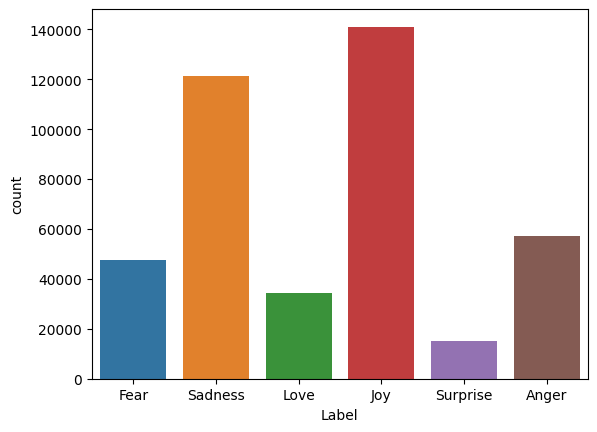

In [9]:
sns.countplot(x ='Label', data = label_df)

### Create Seperate Data for Word Clouds

In [10]:
df_sadness = label_df[label_df['Label']=='Sadness']
df_joy = label_df[label_df['Label']=='Joy']
df_love = label_df[label_df['Label']=='Love']
df_anger = label_df[label_df['Label']=='Anger']
df_fear = label_df[label_df['Label']=='Fear']
df_surprise = label_df[label_df['Label']=='Surprise']

Combine test from different emotions.

In [11]:
combined_sadness_text = ' '.join(df_sadness['Text'])
combined_joy_text = ' '.join(df_joy['Text'])
combined_love_text = ' '.join(df_love['Text'])
combined_anger_text = ' '.join(df_anger['Text'])
combined_fear_text = ' '.join(df_fear['Text'])
combined_surprise_text = ' '.join(df_surprise['Text'])

Create Word Clouds

In [12]:
sadness_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_sadness_text)
joy_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_joy_text)
love_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_love_text)
anger_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_anger_text)
fear_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_fear_text)
surprise_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_surprise_text)

Plot the WordClouds.

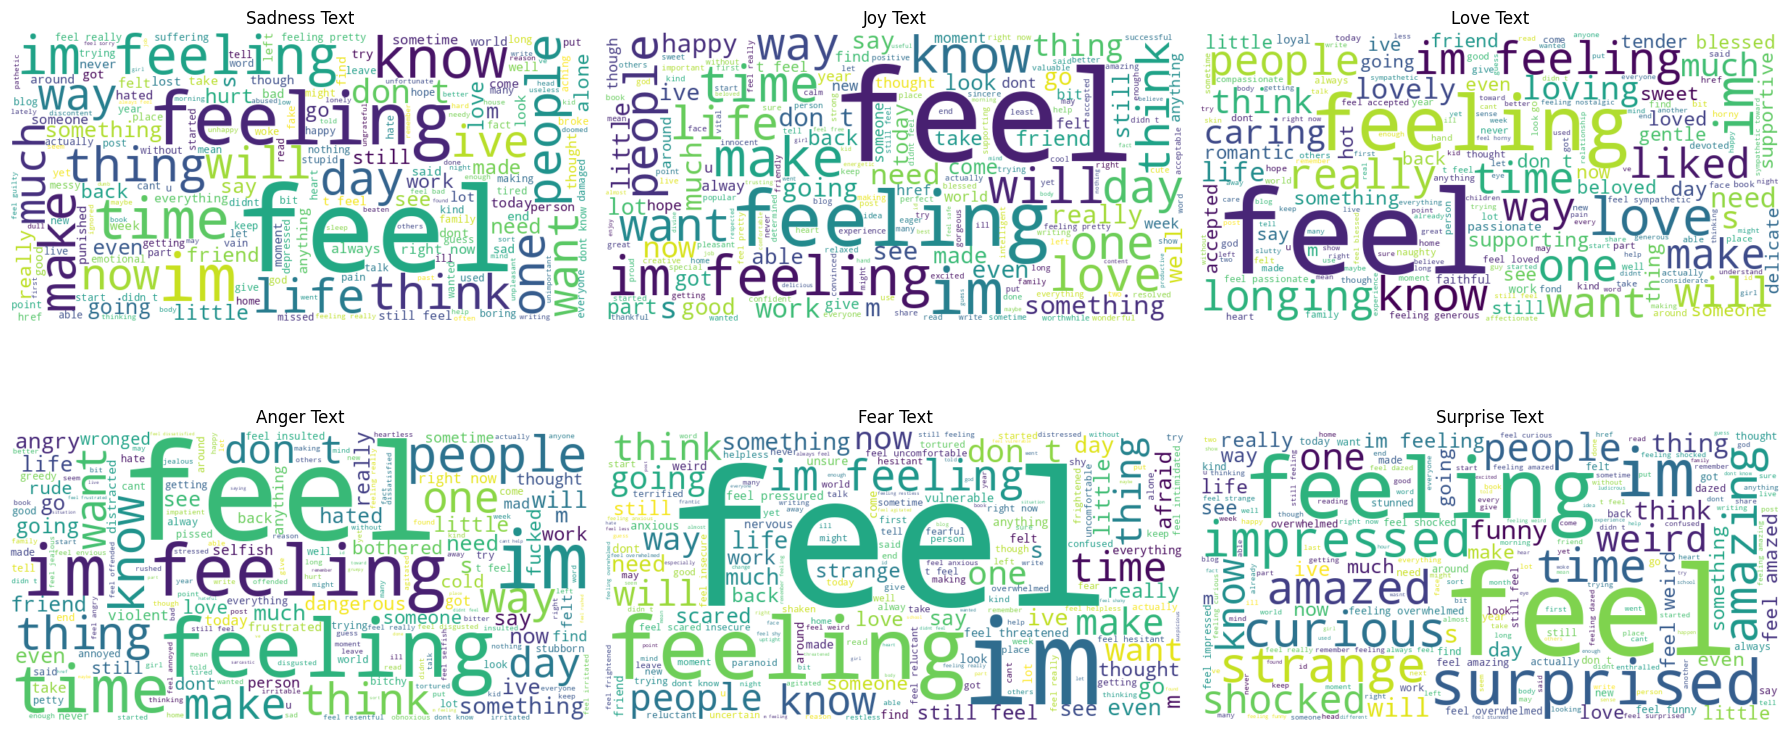

In [13]:
plt.figure(figsize=(18, 9))

plt.subplot(2, 3, 1)
plt.imshow(sadness_wordcloud, interpolation='bilinear')
plt.title('Sadness Text')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(joy_wordcloud, interpolation='bilinear')
plt.title('Joy Text')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(love_wordcloud, interpolation='bilinear')
plt.title('Love Text')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(anger_wordcloud, interpolation='bilinear')
plt.title('Anger Text')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(fear_wordcloud, interpolation='bilinear')
plt.title('Fear Text')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(surprise_wordcloud, interpolation='bilinear')
plt.title('Surprise Text')
plt.axis('off')

plt.tight_layout()
plt.show()

# Text Preprocessing

In [14]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Remove URLs

In [15]:
df['Text'] = df['Text'].str.replace(r'http\S+', '', regex=True)
print(df.head())

                                                Text  Label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4
3                         i dont know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4


### Remove special characters and puctuation.

In [16]:
df['Text'] = df['Text'].str.replace(r'[^\w\s]', '', regex=True)
print(df.head())

                                                Text  Label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4
3                         i dont know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4


### Remove extra whitespaces.

In [17]:
df['Text'] = df['Text'].str.replace(r'\s+', ' ', regex=True)
print(df.head())

                                                Text  Label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4
3                         i dont know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4


### Remove Numeric Values in Text

In [18]:
df['Text'] = df['Text'].str.replace(r'\d+', '', regex=True)
df.head()

,Text,Label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


### Lowercase all text.

In [19]:
df['Text'] = df['Text'].str.lower()
print(df.head())

                                                Text  Label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4
3                         i dont know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4


### Remove Stopwords.

In [20]:
stop = stopwords.words('english')
df["Text"] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df.head()

,Text,Label
0,feel really helpless heavy hearted,4
1,ive enjoyed able slouch relax unwind frankly n...,0
2,gave internship dmrg feeling distraught,4
3,dont know feel lost,0
4,kindergarten teacher thoroughly weary job take...,4


### Remove all non-alpha numeric characters.

In [21]:
df['Text'] = df['Text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
df.head()

,Text,Label
0,feel really helpless heavy hearted,4
1,ive enjoyed able slouch relax unwind frankly n...,0
2,gave internship dmrg feeling distraught,4
3,dont know feel lost,0
4,kindergarten teacher thoroughly weary job take...,4
